In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from surprise import KNNWithMeans
from surprise import SVD, SVDpp
from surprise import KNNBaseline
from surprise import KNNBasic
from surprise import KNNWithZScore
from surprise import BaselineOnly
from surprise import Dataset
from surprise import Reader
from surprise import accuracy
from surprise.model_selection import train_test_split
from surprise.model_selection import cross_validate
from surprise.model_selection import KFold
from surprise.model_selection import GridSearchCV
import time
from collections import defaultdict

In [3]:
dataset = pd.read_csv("dataset_recommendation.csv", sep=";")

In [4]:
#GET SHAPE
rows_count, columns_count = dataset.shape
print('Total Number of rows :', rows_count)
print('Total Number of columns :', columns_count)

Total Number of rows : 100801
Total Number of columns : 4


In [5]:
#UNIQUE VALUES
unique_userId = dataset['customer_unique_id'].nunique()
unique_productId = dataset['product_id'].nunique()
print('Total number of unique Users    : ', unique_userId)
print('Total number of unique Products : ', unique_productId)

Total number of unique Users    :  94006
Total number of unique Products :  32541


In [6]:
dataset.apply(lambda x : sum(x.isna()))

customer_unique_id       0
product_id               0
review_score             0
product_category_name    0
dtype: int64

In [8]:
#Dataset with n of reviews for each label
rating_counts = pd.DataFrame(dataset['review_score'].value_counts()).reset_index()
rating_counts.columns = ['Labels', 'Ratings']
rating_counts

,Labels,Ratings
0,5,58254
1,4,19428
2,1,11577
3,3,8330
4,2,3212


C:\Users\marco\anaconda3\envs\datavis\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


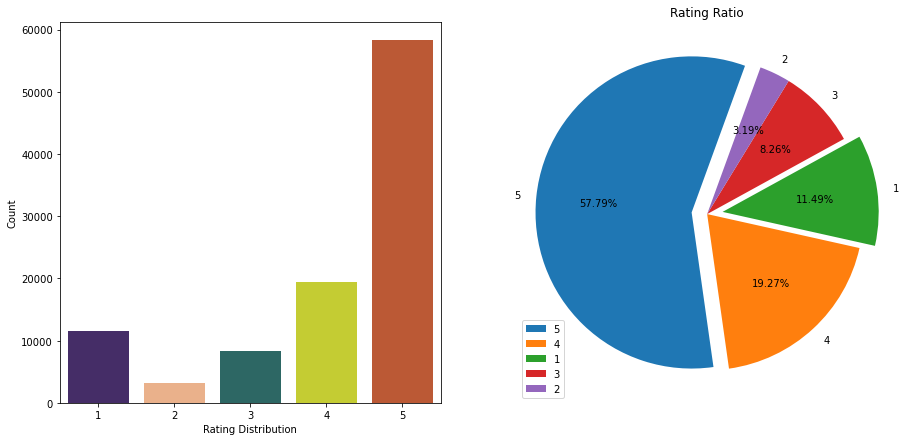

In [9]:
#graph review
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15,7))
sns.countplot(dataset['review_score'], ax=ax1, palette=['#432371',"#FAAE7B", "#23716d", "#dbe619", "#d14f1f"])
ax1.set_xlabel('Rating Distribution', fontsize=10)
ax1.set_ylabel('Count', fontsize=10)

explode = (0.1, 0, 0.1, 0, 0)
ax2.pie(rating_counts["Ratings"], explode=explode, labels=rating_counts.Labels, autopct='%1.2f%%',
        shadow=False, startangle=70)
ax2.axis('equal')
plt.title("Rating Ratio")
plt.legend(rating_counts.Labels, loc=3)
plt.show()

The dataset is subsetted in a smaller matrix with onyl people who reviewed at leas 2 product, and products receiveing at leas two reviews

In [10]:
#SUBSETTING THE DATASET
df_start = dataset.drop(["product_category_name"], axis=1)

users_counts = df_start['customer_unique_id'].value_counts().rename('users_counts')
users_data   = df_start.merge(users_counts.to_frame(),
                                left_on='customer_unique_id',
                                right_index=True)
subset_df = users_data[users_data.users_counts >= 2]

#product with at least two reviews
product_rating_counts = subset_df['product_id'].value_counts().rename('product_rating_counts')
product_rating_data   = subset_df.merge(product_rating_counts.to_frame(),
                                left_on='product_id',
                                right_index=True)
product_rating_data = product_rating_data[product_rating_data.product_rating_counts >= 2]

In [11]:
#START
df1 = product_rating_data.copy()

panda_data = df1.drop(['users_counts', 'product_rating_counts'], axis=1)#remove the useless columns

reader = Reader(rating_scale=(1, 5))
surprise_data = Dataset.load_from_df(panda_data[['customer_unique_id', 'product_id', 'review_score']], reader)#transforming so surprise format
trainset, testset = train_test_split(surprise_data, test_size=.30, random_state=42) #test and train set

## COLLABORATIVE SYSTEM

In [12]:
#BEST PARAMETERS FOR SVD

cv_results = [] #list to store result

svd_param_grid = {'n_epochs': [20, 25], 'lr_all': [0.007, 0.009, 0.01], 'reg_all': [0.4, 0.6]}

svd_gs = GridSearchCV(SVD, svd_param_grid, measures=['rmse', 'mae'], cv=5, n_jobs=5)
svdpp_gs = GridSearchCV(SVDpp, svd_param_grid, measures=['rmse', 'mae'], cv=5, n_jobs=5)

svd_gs.fit(surprise_data)
svdpp_gs.fit(surprise_data)

# best RMSE score
print(svd_gs.best_score['rmse'])
print(svdpp_gs.best_score['rmse'])

# combination of parameters that gave the best RMSE score
print(svd_gs.best_params['rmse'])
print(svdpp_gs.best_params['rmse'])

1.3845791088518604
1.3764778172683185
{'n_epochs': 20, 'lr_all': 0.007, 'reg_all': 0.6}
{'n_epochs': 20, 'lr_all': 0.007, 'reg_all': 0.6}


In [13]:
#TEST
start_time = time.time()

# Creating Model using best parameters
svd_model = SVD(n_epochs=20, lr_all=0.007, reg_all=0.6)

# Training the algorithm on the trainset
svd_model.fit(trainset)

# Predicting for test set
predictions_svd = svd_model.test(testset)

# Evaluating RMSE, MAE of algorithm SVD on 5 split(s) by cross validation
svd_cv = cross_validate(svd_model, surprise_data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

# Storing Crossvalidation Results in dataframe
svd_df = pd.DataFrame.from_dict(svd_cv)
svd_described = svd_df.describe()
cv_results = pd.DataFrame([['SVD', svd_described['test_rmse']['mean'], svd_described['test_mae']['mean'],
                           svd_described['fit_time']['mean'], svd_described['test_time']['mean']]],
                            columns = ['Model', 'RMSE', 'MAE', 'Fit Time', 'Test Time'])


# get RMSE
print("\n\n==================== Model Evaluation ===============================")
accuracy.rmse(predictions_svd, verbose=True)
print("=====================================================================")
computational_time = time.time() - start_time
print('\n Computational Time : %0.3fs' %(computational_time))
print(cv_results)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.3885  1.3812  1.3498  1.3765  1.3982  1.3788  0.0163  
MAE (testset)     1.0902  1.0909  1.0686  1.1000  1.0949  1.0889  0.0107  
Fit time          0.62    0.65    0.45    0.42    0.45    0.52    0.10    
Test time         0.02    0.02    0.01    0.02    0.02    0.02    0.00    


==================== Model Evaluation ===============================
RMSE: 1.3536

 Computational Time : 3.880s
  Model      RMSE       MAE  Fit Time  Test Time
0   SVD  1.378837  1.088901  0.518036   0.016801


In [14]:
#2ND

start_time = time.time()
# Creating Model using best parameters
svdpp_model = SVDpp(n_epochs=20, lr_all=0.007, reg_all=0.6)

# Training the algorithm on the trainset
svdpp_model.fit(trainset)

# Predicting for test set
predictions_svdpp = svdpp_model.test(testset)

# Evaluating RMSE, MAE of algorithm SVDpp on 5 split(s) by cross validation
svdpp_cv = cross_validate(svdpp_model, surprise_data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

# Storing Crossvalidation Results in dataframe
svdpp_df = pd.DataFrame.from_dict(svdpp_cv)
svdpp_described = svdpp_df.describe()
svdpp_cv_results = pd.DataFrame([['SVDpp', svdpp_described['test_rmse']['mean'], svdpp_described['test_mae']['mean'],
                           svdpp_described['fit_time']['mean'], svdpp_described['test_time']['mean']]],
                            columns = ['Model', 'RMSE', 'MAE', 'Fit Time', 'Test Time'])

cv_results = cv_results.append(svdpp_cv_results, ignore_index=True)

# get RMSE
print("\n\n==================== Model Evaluation ===============================")
accuracy.rmse(predictions_svdpp, verbose=True)
print("=====================================================================")
computational_time = time.time() - start_time
print('\n Computational Time : %0.3fs' %(computational_time))
print(cv_results)

Evaluating RMSE, MAE of algorithm SVDpp on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.3416  1.3597  1.3892  1.3880  1.4049  1.3767  0.0228  
MAE (testset)     1.0523  1.0750  1.1043  1.1032  1.1050  1.0879  0.0211  
Fit time          0.82    0.87    0.86    0.82    1.09    0.89    0.10    
Test time         0.03    0.02    0.02    0.03    0.05    0.03    0.01    


==================== Model Evaluation ===============================
RMSE: 1.3559

 Computational Time : 6.240s
   Model      RMSE       MAE  Fit Time  Test Time
0    SVD  1.378837  1.088901  0.518036   0.016801
1  SVDpp  1.376688  1.087950  0.891870   0.030400


In [15]:
#KNN OPTIMAL PARAMS
start_time = time.time()

knn_param_grid = {'bsl_options': {'method': ['als', 'sgd'],
                              'reg': [1, 2]},
              'k': [15, 20, 25, 30, 40, 50, 60],
              'sim_options': {'name': ['msd', 'cosine', 'pearson_baseline']}
              }

knnbasic_gs = GridSearchCV(KNNBasic, knn_param_grid, measures=['rmse', 'mae'], cv=5, n_jobs=5)
knnbasic_gs.fit(surprise_data)
print(knnbasic_gs.best_score['rmse'])
print(knnbasic_gs.best_params['rmse'])

computational_time = time.time() - start_time
print('\nComputational Time : %0.3fs' %(computational_time))

1.420162633499861
{'bsl_options': {'method': 'sgd', 'reg': 2}, 'k': 15, 'sim_options': {'name': 'pearson_baseline', 'user_based': True}}

Computational Time : 55.820s


In [16]:
#KNN BASIC
start_time = time.time()
knnBasic_model = KNNBasic(k=15,sim_options= {'name': 'pearson_baseline', 'user_based': True} )

# Training the algorithm on the trainset
knnBasic_model.fit(trainset)

# Predicting for test set
prediction_knnBasic = knnBasic_model.test(testset)

# Evaluating RMSE, MAE of algorithm KNNBasic on 5 split(s)
knnBasic_cv = cross_validate(knnBasic_model, surprise_data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

# Storing Crossvalidation Results in dataframe
knnBasic_df = pd.DataFrame.from_dict(knnBasic_cv)
knnBasic_described = knnBasic_df.describe()
knnBasic_cv_results = pd.DataFrame([['KNNBasic', knnBasic_described['test_rmse']['mean'], knnBasic_described['test_mae']['mean'],
                           knnBasic_described['fit_time']['mean'], knnBasic_described['test_time']['mean']]],
                            columns = ['Model', 'RMSE', 'MAE', 'Fit Time', 'Test Time'])


cv_results = cv_results.append(knnBasic_cv_results, ignore_index=True)

# get RMSE
print("\n\n==================== Model Evaluation ===============================")
accuracy.rmse(prediction_knnBasic, verbose=True)
print("=====================================================================")

computational_time = time.time() - start_time
print('\n Computational Time : %0.3fs' %(computational_time))
print(cv_results)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MAE of algorithm KNNBasic on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.4671  1.3980  1.3867  1.3817  1.4645  1.4196  0.0381  
MAE (testset)     1.1382  1.0617  1.0591  1.0618  1.1329  1.0908  0.0366  
Fit time      

In [20]:
k = 5
top_n = defaultdict(list)
def get_top_n(predictions, n=k):
    # First map the predictions to each user.
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n

top_n = get_top_n(predictions_svd, n=k)
first_three_items = list(top_n.items())[:3]
print(first_three_items)

[('b2bd387fdc3cf05931f0f897d607dc88', [('99f5b2240b82bf9387e5cf2fc0335b08', 4.294290606706752), ('e3323b0d3f79bdf85b58561d2218bc12', 4.22248818307212), ('36f60d45225e60c7da4558b070ce4b60', 4.209690186229823)]), ('318dd674b6e789249337a1edca1b0cc1', [('99a4788cb24856965c36a24e339b6058', 4.05118826983023), ('35afc973633aaeb6b877ff57b2793310', 3.951892095349444)]), ('f30856ad31d3e74253a3f4ccef670648', [('36f60d45225e60c7da4558b070ce4b60', 4.116715556462719)])]
